In [46]:
import pandas as pd
import transformers
from datasets import Dataset, Value, ClassLabel, Features
import matplotlib.pyplot as plt
import warnings
import json
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
import numpy as np 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# can be monolingual or multilingual, depending on the task
task = "monolingual"


In [51]:
def get_device():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    return device
    
device = get_device()

if task == "monolingual":
    model_ckpt = "distilbert-base-uncased"
    train_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_train_monolingual.jsonl"
    val_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_dev_monolingual.jsonl"
else:
    model_ckpt = "distilbert-base-multilingual-cased"
    train_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_train_multilingual.jsonl"
    val_path = "../data/SemEval2024-Task8/SubtaskA/subtaskA_dev_multilingual.jsonl"


In [52]:
def read_jsonl(path):
    data = []
    with open(path, "r") as f:
        for line in f:
            json_data = json.loads(line)
            data.append(json_data)
    return data


def get_pandas_dfs(train_path=train_path, val_path=val_path, train_sample=None, val_sample=None):
    train_data = read_jsonl(train_path)
    val_data = read_jsonl(val_path)

    train_df = pd.DataFrame(train_data).loc[:, ["text", "label"]]
    train_df["label"] = train_df["label"].map(lambda x: "LLM" if x==1 else "human")
    val_df = pd.DataFrame(val_data).loc[:, ["text", "label"]]
    val_df["label"] = val_df["label"].map(lambda x: "LLM" if x==1 else "human")
    
    if train_sample:
        train_df = train_df.sample(n=train_sample, random_state=42).reset_index(drop=True)
    if val_sample:
        val_df = val_df.sample(n=val_sample, random_state=42).reset_index(drop=True)
    
    return train_df, val_df

def prepare_datasets(train_df, val_df):
    class_names = ["human", "LLM"]
    features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=2, names=class_names)})

    train_ds = Dataset.from_pandas(train_df, features=features)
    val_ds = Dataset.from_pandas(val_df, features=features)
    
    return train_ds, val_ds

train_df, test_df = get_pandas_dfs(train_sample=1000, val_sample=100)
train_ds, val_ds = prepare_datasets(train_df, test_df)

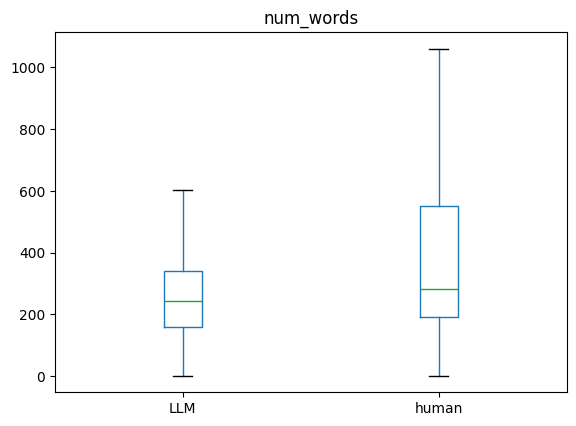

In [53]:
train_df["num_words"] = train_df["text"].apply(lambda x: len(x.split()))
train_df.boxplot(column="num_words", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

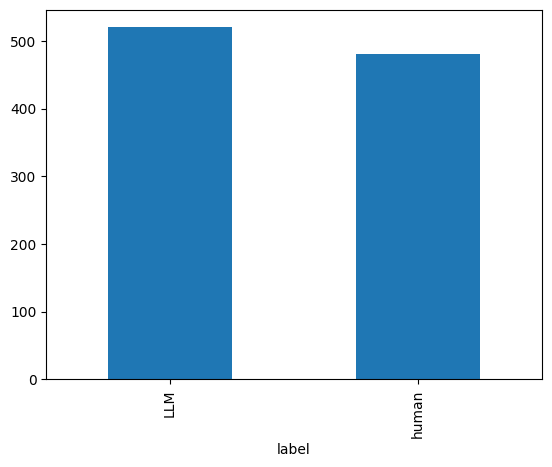

In [54]:
train_df["label"].value_counts().plot.bar()
plt.show()

In [55]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

def extract_hidden_states(batch):
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='pt').to(device)
    with torch.inference_mode():
        outputs = model(**inputs)
    # TODO: add other features (mean, max of embeddings)
    return {"cls_embedding": outputs.last_hidden_state[:, 0].cpu()}

train_ds_embeddings = train_ds.map(extract_hidden_states, batched=True, batch_size=128)
test_ds_embeddings = val_ds.map(extract_hidden_states, batched=True, batch_size=128)

tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 115kB/s]
config.json: 100%|██████████| 466/466 [00:00<00:00, 906kB/s]
vocab.txt: 100%|██████████| 996k/996k [00:00<00:00, 2.46MB/s]
tokenizer.json: 100%|██████████| 1.96M/1.96M [00:01<00:00, 1.23MB/s]
model.safetensors: 100%|██████████| 542M/542M [00:17<00:00, 31.2MB/s]
Map: 100%|██████████| 100/100 [00:08<00:00, 11.70 examples/s]


In [56]:
X_train = np.array(train_ds_embeddings["cls_embedding"]) 
X_val = np.array(test_ds_embeddings["cls_embedding"]) 
y_train = np.array(train_ds_embeddings["label"]) 
y_val = np.array(test_ds_embeddings["label"]) 

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1000, 768), (100, 768), (1000,), (100,))

In [57]:
lr_clf = LogisticRegression(max_iter=3000) 
lr_clf.fit(X_train, y_train) 
print(f"Logistic Regression accuracy: {lr_clf.score(X_val, y_val)}")

xgb = XGBClassifier()
xgb.fit(X_train, y_train) 
print(f"XGB accuracy: {xgb.score(X_val, y_val)}")

Logistic Regression accuracy: 0.52
XGB accuracy: 0.49


In [58]:
training_args = TrainingArguments("SemEval-Trainer", evaluation_strategy="epoch", num_train_epochs=5)

classifier = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")

train_ds_encoded = train_ds.map(tokenize, batched=True)
val_ds_encoded = val_ds.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 100/100 [00:00<00:00, 2473.95 examples/s]


In [59]:
def compute_metrics(eval_preds):
    metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)

trainer = Trainer(
    classifier,
    training_args,
    train_dataset=train_ds_encoded,
    eval_dataset=val_ds_encoded,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model(f"fine_tuned_distilbert_for_{task}.pt")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.










KeyboardInterrupt: 